## Import Library

In [22]:
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras import layers, models
#from tensorflow.keras.applications import MobileNetV2
#from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
#from tensorflow.keras.applications import Xception
#from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os

ModuleNotFoundError: No module named 'tensorflow.compat'

In [14]:
import tensorflow as tf
print(tf.__version__)
print(tf.compat.v1)

AttributeError: module 'tensorflow' has no attribute '__version__'

## Preprocessing Data

In [6]:
data_dir = 'hama'

# Preprocessing dan load dataset
img_height, img_width = 180, 180
batch_size = 16

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)

# Membagi Test dan Valid 50:50
val_batches = int(0.5 * tf.data.experimental.cardinality(val_test_ds).numpy())  # bagi dua

val_ds = val_test_ds.take(val_batches)
test_ds = val_test_ds.skip(val_batches)

# Optional: Menambahkan prefetching untuk performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1400 files belonging to 2 classes.
Using 1120 files for training.
Found 1400 files belonging to 2 classes.
Using 280 files for validation.


In [38]:
print(class_names)

['invasive', 'noninvasive']


## Bangun Arsitektur Model

In [8]:
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       5,308,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,697,345 (21.73 MB)

 Trainable params: 5,697,345 (21.73 MB)

 Non-trainable params: 0 (0.00 B)

## Training Loop

In [9]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 167ms/step - accuracy: 0.5492 - loss: 0.7668 - val_accuracy: 0.4722 - val_loss: 0.7214
Epoch 2/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 166ms/step - accuracy: 0.6352 - loss: 0.6367 - val_accuracy: 0.7222 - val_loss: 0.5441
Epoch 3/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - accuracy: 0.7441 - loss: 0.5661 - val_accuracy: 0.7292 - val_loss: 0.5430
Epoch 4/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - accuracy: 0.7701 - loss: 0.5056 - val_accuracy: 0.7361 - val_loss: 0.5907
Epoch 5/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - accuracy: 0.8219 - loss: 0.4140 - val_accuracy: 0.7639 - val_loss: 0.4547
Epoch 6/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 165ms/step - accuracy: 0.8447 - loss: 0.3621 - val_accuracy: 0.8403 - val_loss: 0.3567
Epoch 7/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - accuracy: 0.9005 - loss: 0.2624 - val_accuracy: 0.8611 - val_loss: 0.2802
Epoch 8/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - accuracy: 0.9028 - loss: 0.2512 - val_accu

## Testing Model

In [10]:
test_loss, test_accuracy = model.evaluate(test_ds)
print("Testing accuracy:", test_accuracy)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8877 - loss: 0.4474
Testing accuracy: 0.8897058963775635


C:\Users\ENZ\AppData\Local\Temp\ipykernel_13904\2428943626.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_result, x='Metric', y='Value', palette='Blues_d')


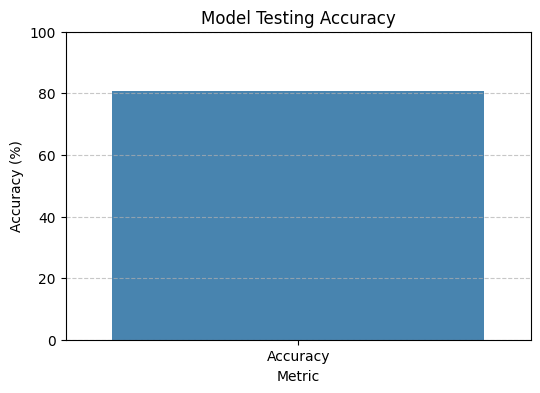

In [17]:
df_result = pd.DataFrame({
    'Metric': ['Accuracy'],
    'Value': [test_accuracy * 100]
})

plt.figure(figsize=(6, 4))
sns.barplot(data=df_result, x='Metric', y='Value', palette='Blues_d')
plt.title("Model Testing Accuracy")
plt.ylim(0, 100)
plt.ylabel("Accuracy (%)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Evaluate Model

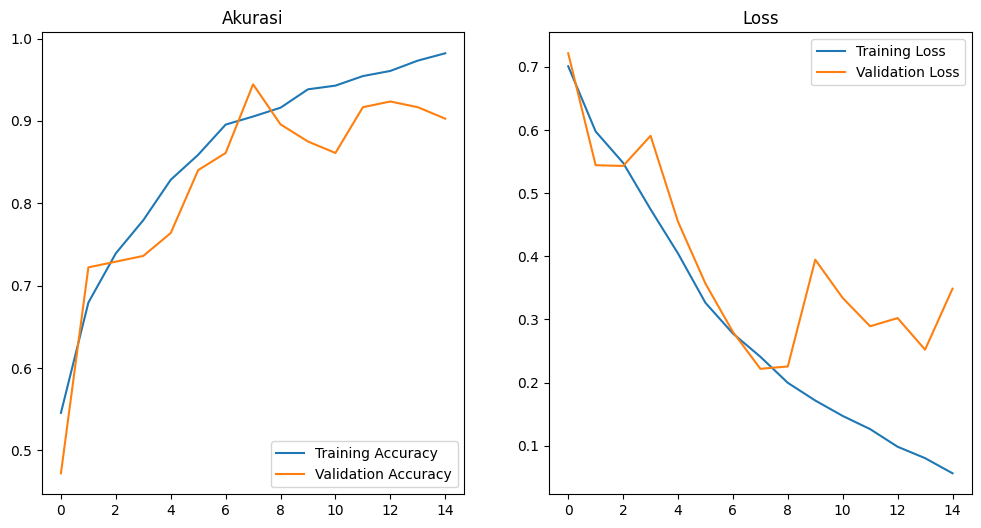

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Akurasi')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

## Transfer Learning - MobileNet

In [13]:
base_model_mobilenet = MobileNetV2(input_shape=(img_height, img_width, 3),
                         include_top=False,
                         weights='imagenet')

base_model_mobilenet.trainable = False  # freeze dulu biar cepat dan stabil

model_mobilenet = models.Sequential([
    layers.InputLayer(input_shape=(180, 180, 3)),
    layers.Lambda(preprocess_input),
    base_model_mobilenet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")  # tanpa softmax karena pakai SparseCategoricalCrossentropy with logits
])

model_mobilenet.summary()

C:\Users\ENZ\AppData\Local\Temp\ipykernel_11192\204675413.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_mobilenet = MobileNetV2(input_shape=(img_height, img_width, 3),


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)                    │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 6, 6, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [18]:
model_mobilenet.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

model_mobilenet.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 27s 252ms/step - accuracy: 0.8752 - loss: 0.4010 - val_accuracy: 0.9236 - val_loss: 0.4688
Epoch 2/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 224ms/step - accuracy: 0.9211 - loss: 0.1808 - val_accuracy: 0.9097 - val_loss: 0.4724
Epoch 3/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 228ms/step - accuracy: 0.9700 - loss: 0.0838 - val_accuracy: 0.8611 - val_loss: 0.6060
Epoch 4/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 17s 235ms/step - accuracy: 0.9845 - loss: 0.0521 - val_accuracy: 0.4792 - val_loss: 10.3080
Epoch 5/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 220ms/step - accuracy: 0.9806 - loss: 0.0379 - val_accuracy: 0.9306 - val_loss: 0.6056


In [19]:
test_loss, test_accuracy = model_mobilenet.evaluate(test_ds)
print("Testing accuracy:", test_accuracy)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.8726 - loss: 1.2868
Testing accuracy: 0.8823529481887817


In [20]:
#Fine Tuning Mobilenet
base_model_mobilenet.trainable = True
fine_tune_at = 100
for layer in base_model_mobilenet.layers[:fine_tune_at]:
    layer.trainable = False

model_mobilenet.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # learning rate kecil biar stabil
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

model_mobilenet.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 26s 234ms/step - accuracy: 0.9845 - loss: 0.0538 - val_accuracy: 0.9375 - val_loss: 0.5604
Epoch 2/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 214ms/step - accuracy: 0.9990 - loss: 0.0058 - val_accuracy: 0.9375 - val_loss: 0.5228
Epoch 3/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 213ms/step - accuracy: 0.9988 - loss: 0.0034 - val_accuracy: 0.9375 - val_loss: 0.5029
Epoch 4/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 211ms/step - accuracy: 0.9998 - loss: 0.0031 - val_accuracy: 0.9375 - val_loss: 0.4975
Epoch 5/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 212ms/step - accuracy: 1.0000 - loss: 0.0030 - val_accuracy: 0.9306 - val_loss: 0.5072


In [21]:
test_loss, test_accuracy = model_mobilenet.evaluate(test_ds)
print("Testing accuracy:", test_accuracy)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.8726 - loss: 1.0629
Testing accuracy: 0.8970588445663452


## Transfer Learning - Xception

In [22]:
base_model_xception = Xception(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)

base_model_xception.trainable = False  # freeze feature extractor

model_xception = models.Sequential([
    layers.InputLayer(input_shape=(180, 180, 3)),
    layers.Lambda(preprocess_input),
    base_model_xception,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')  # binary classification
])

model_xception.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       5,308,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,092,037 (65.20 MB)

 Trainable params: 5,697,345 (21.73 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,394,692 (43.47 MB)

In [23]:
model_xception.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 32s 410ms/step - accuracy: 0.8393 - loss: 0.3759 - val_accuracy: 0.9028 - val_loss: 0.2165
Epoch 2/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 28s 395ms/step - accuracy: 0.9012 - loss: 0.2392 - val_accuracy: 0.9097 - val_loss: 0.2446
Epoch 3/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 28s 393ms/step - accuracy: 0.9303 - loss: 0.1978 - val_accuracy: 0.9236 - val_loss: 0.2102
Epoch 4/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 28s 398ms/step - accuracy: 0.9430 - loss: 0.1509 - val_accuracy: 0.9028 - val_loss: 0.2752
Epoch 5/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 27s 393ms/step - accuracy: 0.9374 - loss: 0.1438 - val_accuracy: 0.9236 - val_loss: 0.2315


In [24]:
test_loss, test_accuracy = model_xception.evaluate(test_ds)
print("Testing accuracy:", test_accuracy)

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 332ms/step - accuracy: 0.8253 - loss: 0.4333
Testing accuracy: 0.8676470518112183


In [27]:
# Fine Tuning Xception
base_model_xception.trainable = True
for layer in base_model_xception.layers[:100]:
    layer.trainable = False

# Compile ulang dengan learning rate kecil
model_xception.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Latih ulang
history_finetune = model_xception.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 67s 848ms/step - accuracy: 0.8519 - loss: 0.4444 - val_accuracy: 0.9444 - val_loss: 0.1976
Epoch 2/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 58s 831ms/step - accuracy: 0.9889 - loss: 0.0484 - val_accuracy: 0.9236 - val_loss: 0.2946
Epoch 3/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 58s 831ms/step - accuracy: 0.9942 - loss: 0.0156 - val_accuracy: 0.9306 - val_loss: 0.3689
Epoch 4/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 58s 828ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.9236 - val_loss: 0.4013
Epoch 5/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 59s 838ms/step - accuracy: 1.0000 - loss: 9.0936e-04 - val_accuracy: 0.9236 - val_loss: 0.4262


In [28]:
test_loss, test_accuracy = model_xception.evaluate(test_ds)
print("Testing accuracy:", test_accuracy)

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 341ms/step - accuracy: 0.8353 - loss: 0.8400
Testing accuracy: 0.8823529481887817


## Transfer Learning - ResNET

In [30]:
base_model_resnet = tf.keras.applications.ResNet50(
    input_shape= (img_height, img_width) + (3,),
    include_top=False,
    weights='imagenet'
)
base_model_resnet.trainable = False

model_resnet = models.Sequential([
    layers.InputLayer(input_shape=(180, 180, 3)),
    layers.Lambda(preprocess_input),
    base_model_resnet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model_resnet.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_resnet.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_4 (Lambda)                    │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 6, 6, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [31]:
model_resnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 33s 403ms/step - accuracy: 0.6362 - loss: 0.6959 - val_accuracy: 0.7431 - val_loss: 0.5293
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 26s 378ms/step - accuracy: 0.7477 - loss: 0.5233 - val_accuracy: 0.7708 - val_loss: 0.4574
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 26s 376ms/step - accuracy: 0.7704 - loss: 0.4946 - val_accuracy: 0.7500 - val_loss: 0.5453
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 26s 377ms/step - accuracy: 0.7895 - loss: 0.4463 - val_accuracy: 0.7917 - val_loss: 0.4287
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 26s 377ms/step - accuracy: 0.8218 - loss: 0.3882 - val_accuracy: 0.7708 - val_loss: 0.4548
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 27s 379ms/step - accuracy: 0.7851 - loss: 0.4413 - val_accuracy: 0.7986 - val_loss: 0.4368
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 27s 384ms/step - accuracy: 0.7899 - loss: 0.4485 - val_accuracy: 0.7917 - val_loss: 0.4319
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 27s 379ms/step - accuracy: 0.7935 - loss: 0.4169 - val_accu

In [32]:
test_loss_resnet, test_accuracy_resnet = model_resnet.evaluate(test_ds)
print("Testing accuracy:", test_accuracy_resnet)

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 312ms/step - accuracy: 0.7683 - loss: 0.4559
Testing accuracy: 0.7720588445663452


In [33]:
# Fine Tuning Resnet
base_model_resnet.trainable = True
for layer in base_model_resnet.layers[:100]:
    layer.trainable = False

# Compile ulang dengan learning rate kecil
model_resnet.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Latih ulang
model_resnet.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 80s 925ms/step - accuracy: 0.7040 - loss: 1.1033 - val_accuracy: 0.7639 - val_loss: 0.4806
Epoch 2/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 61s 876ms/step - accuracy: 0.8253 - loss: 0.3901 - val_accuracy: 0.8125 - val_loss: 0.4160
Epoch 3/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 65s 925ms/step - accuracy: 0.8877 - loss: 0.2461 - val_accuracy: 0.6111 - val_loss: 0.7689
Epoch 4/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 65s 922ms/step - accuracy: 0.9517 - loss: 0.1411 - val_accuracy: 0.8472 - val_loss: 0.3704
Epoch 5/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 64s 919ms/step - accuracy: 0.9185 - loss: 0.2044 - val_accuracy: 0.7639 - val_loss: 0.5256


In [34]:
test_loss_resnet, test_accuracy_resnet = model_resnet.evaluate(test_ds)
print("Testing accuracy:", test_accuracy_resnet)

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - accuracy: 0.7294 - loss: 0.5424
Testing accuracy: 0.7279411554336548


- Dapat

## Saved Model

In [36]:
# Saved Model Biasa
model.export('models/saved_model')

INFO:tensorflow:Assets written to: models/saved_model\assets


INFO:tensorflow:Assets written to: models/saved_model\assets


Saved artifact at 'models/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name='keras_tensor_12')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2121711776016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2121711977568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2121711771792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2121711980208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2121711979504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2121711978976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2121711982672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2121711981792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2121711984608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2121711980384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2121711986896: TensorSpec(sha

In [41]:
# Tensorflow Lite Label

# Path simpan label.txt
label_path = "models/tflite/label.txt"
os.makedirs(os.path.dirname(label_path), exist_ok=True)

# Simpan label ke file
with open(label_path, "w") as f:
    f.write("\n".join(class_names))

print(f"label.txt berhasil dibuat di {label_path}")

label.txt berhasil dibuat di models/tflite/label.txt


In [42]:
# Tensorflow Lite Model + Bobot
saved_model_dir = "models/saved_model"

tflite_output_dir = "models/tflite"
os.makedirs(tflite_output_dir, exist_ok=True)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

# Simpan ke file
tflite_model_path = os.path.join(tflite_output_dir, "model.tflite")
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print(f" Model berhasil dikonversi ke TFLite dan disimpan di: {tflite_model_path}")

 Model berhasil dikonversi ke TFLite dan disimpan di: models/tflite\model.tflite
